In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from torchsampler import ImbalancedDatasetSampler

import torch
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 

from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm
import pandas as pd 

import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
from network import binary_models as models

from sklearn.metrics import recall_score, f1_score, accuracy_score

/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{0.0: 2, 1.0: 1}


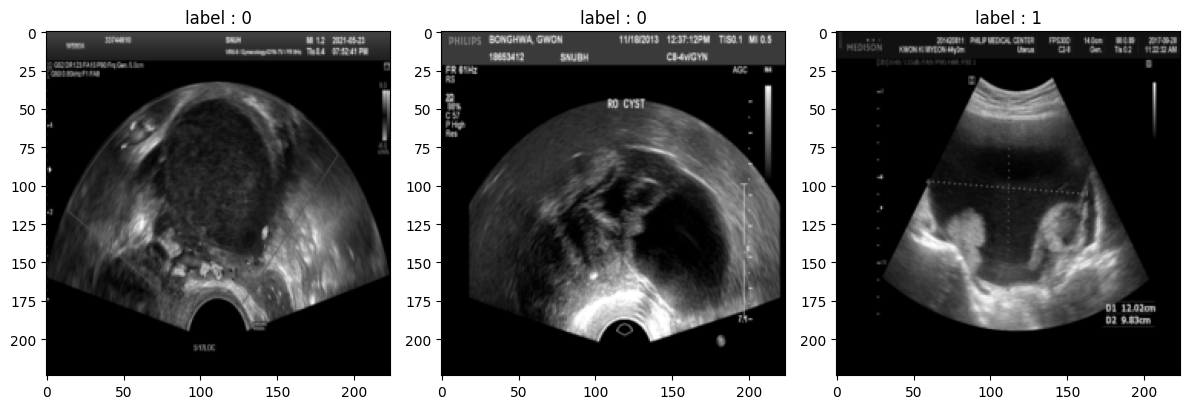

In [2]:
test_dir = '/home/eiden/eiden/DB/octc/data_bin_origin/test'
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    transforms.Grayscale(num_output_channels=3),
])
test_batch = 3
test_dataset = CustomDataset(root_dir = test_dir, transform= test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = test_batch, shuffle= True)

for i, (image, label) in enumerate(test_loader):
    unique, cnts = np.unique(label, return_counts= True)
    print(dict(zip(unique, cnts)))
    plt.figure(figsize= (12, 8))
    plt.subplot(131)
    plt.imshow(image[0,0], cmap ='gray')
    plt.title(f"label : {label[0].int().item()}")
    plt.subplot(132)
    plt.imshow(image[1,0], cmap ='gray')
    plt.title(f"label : {label[1].int().item()}")
    plt.subplot(133)
    plt.imshow(image[2,0], cmap ='gray')
    plt.title(f"label : {label[2].int().item()}")
    plt.tight_layout()
    plt.show()
    break

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###
# checkpoint_path = '../../../models/binary/convnext_original_240404/convnext_original_240404_50_e.pt' #original model
checkpoint_path = '../../../models/binary/convnext_sono_240404/convnext_sono_240404_50_e.pt' #original model
test_model = models.pretrained_convnext_binary().to(device) 

### Swin-T
# checkpoint_path = '../../../models/multi/swin_ours_240404/swin_ours_240404_50.pt' #Ours model
# test_model = models.pretrained_swin_multi().to(device) 

checkpoint = torch.load(checkpoint_path)
weight = checkpoint['model_state_dict']

test_model.load_state_dict(state_dict = weight)
print(f'load complete!! device : {device}')


metrics_dict = {
    'model_name' : [checkpoint_path.split('/binary/')[-1].split('/')[0]],
    "recall": None,
    "specificity": None,
    "ppv": None,
    "npv": None,
    "f1-score": None,
    "acc": None,
    "auroc": None
}


/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load complete!! device : cuda


100%|██████████| 100/100 [00:04<00:00, 22.26it/s]


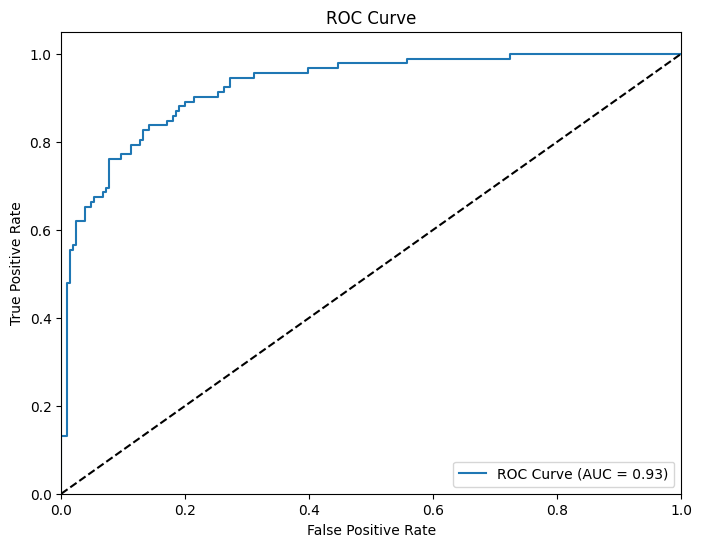

{'model_name': ['convnext_sono_240404'], 'recall': 0.6195652173913043, 'specificity': 0.9660194174757282, 'ppv': 0.890625, 'npv': 0.8504273504273504, 'f1-score': 0.7307692307692307, 'acc': 0.8590604026845637, 'auroc': 0.9254432249894471}


In [4]:
correct = 0
total = 0
pred_labels = []
pred_scores = []
true_labels = []
save_path = os.path.join('../../../models/binary_metric/', checkpoint_path.split('/multi/')[-1].split('/')[0]+'.csv')
from utils.metrics import metric_func, save_metric, plot_roc_curve

with torch.no_grad():
    test_model.eval()
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = test_model(inputs)
        
        pred = (torch.sigmoid(outputs)>0.5).float()
        
        total += labels.size(0)
        correct += (pred == labels).sum().item()

        pred_labels.extend(pred.cpu().numpy())
        pred_scores.extend(torch.sigmoid(outputs).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    metrics_dict = metric_func(true_labels, pred_labels, pred_scores, metrics_dict)
    save_metric(metrics_dict, save_path)
    plot_roc_curve(true_labels, pred_scores)
    print(metrics_dict)
    


In [5]:
import os
import pandas as pd

# CSV 파일 목록 가져오기
csv_dir = '/home/eiden/eiden/octc-classification/models/binary_metric/'
csv_li = os.listdir(csv_dir)
csv_li = [csv for csv in csv_li if csv.endswith('.csv')]

# CSV 파일 읽기 및 데이터프레임에 추가
df = pd.DataFrame()
for csv in csv_li:
    csv_path = os.path.join(csv_dir, csv)
    if os.path.getsize(csv_path) > 0:  # 파일이 비어 있지 않은 경우에만 읽기
        temp = pd.read_csv(csv_path)
        df = pd.concat([df, temp], axis=0)

# 인덱스 리셋하기 (기존 인덱스 제거)
# df.reset_index(drop=True, inplace=True)
# 'model_name' 열에서 선행하는 0 제거
# df['model_name'] = df['model_name'].apply(lambda x: x.lstrip('0'))
df.index = df.index.map(lambda x: str(x).lstrip('0'))
df = df.sort_values(by='model_name', ascending=True)
df


,model_name,recall,specificity,ppv,npv,f1-score,acc,auroc
,convnext_sono_240404,0.619565,0.966019,0.890625,0.850427,0.730769,0.85906,0.925443


# Grad-CAM 

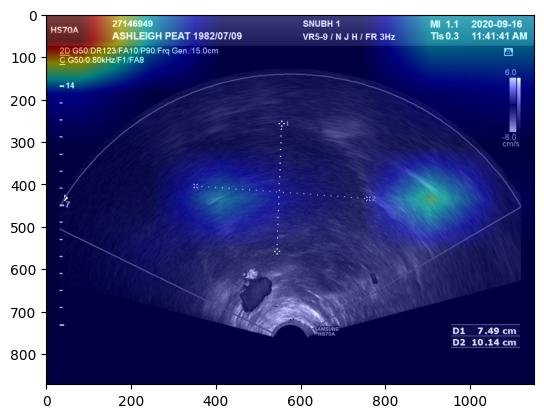

In [6]:
from utils.xai import apply_gradcam

img, cam = apply_gradcam(
    test_model,
    image_path = '/home/eiden/eiden/DB/octc/data_bin_origin/test/0/0_R006_00001.png',
    target_layer=test_model.base_model.features[-1][-3].block[-1],
    # target_layer=test_model.base_model.classifier[-1],
    device = 'cuda'
)

plt.imshow(cam)
